### Week 05 ###

#### Reference: 
http://statsthinking21.org
* Chapter 26: The general linear model
* Chapter 28: Comparing means

#### Topics:

* [Review: relationship between correlation and regression](#Review:-relationship-between-correlation-and-regression)
* [Review: Type 1 and Type 2 regressions](#Review:-Type-1-and-Type-2-regressions)
* [Multivariate regression](#Multivariate-regression)
* [Example: modeling aragonite saturation state](#Example:-modeling-aragonite-saturation-state)
* [Common statistical tests as linear models](#Common-statistical-tests-as-linear-models)

### Load tools and example data

Several examples this week use data from the 2007 West Coast Ocean Acidfication cruise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cbsyst as cb
from scipy import stats
import statsmodels.formula.api as smf

In [2]:
# ignore warning messages
import warnings
warnings.simplefilter('ignore')

In [3]:
filename07 = 'data/week03_wcoa_cruise_2007/32WC20070511.exc.csv'
df07 = pd.read_csv(filename07,header=29,na_values=-999,
                  parse_dates=[[6,7]])

Csw07 = cb.Csys(DIC=df07['TCARBN'],
             TA=df07['ALKALI'],
             T_in=df07['CTDTMP'],
             S_in=df07['CTDSAL'],
             P_in=df07['CTDPRS'])

Ca = 0.0102821 # Calcium ion concentration
df07['OmegaA'] = (Ca*Csw07['CO3'])/(Csw07.Ks['KspA']*1e6)

### Review: relationship between correlation and regression ###

The concepts of correlation and regression are closely related. The correlation coefficient $r$ is given by the relationship

$$ r = \frac{s_{xy}}{s_x s_y}$$

where $s_{xy}$ is the covariance between the $x$ variable and the $y$ variable, $s_x$ is the standard deviation of the $x$ variable and $s_y$ is the standard deviation of the $y$ variable.

In the linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x, $$

the ordinary least squares regression slope $\hat{a}_2$ is given by the relationship

$$ \hat{a}_2 = \frac{s_{xy}}{s_x s_x} $$

This means that the relationship betweeen the correlation coefficient $r$ and the least squares regression slope $\hat{a}_2$ is 

$$ r = \hat{a}_2 \frac{s_y}{s_x}.$$

This has several important implications:
* $r$ and $a_2$ always have the same sign ($r$ is negative when the regression line has negative slope)
* If $r = 0$, then 
    * $\hat{a}_2 = 0$
    * $s_{xy} = 0$
    
There is also a close relationship between testing the null hypothesis of zero correlation and the confidence intervals on the regression slope. If the null hypothesis can be rejected at a given confidence level, then the confidence intervals of the slope will not include zero.

### Review: Type 1 and Type 2 regressions ###

To examine some limitations of the Type 1 regression approach, and motivations for the Type 2 regression approach, we will examine the relationship between nitrate and phosphate at the 30-300m depth range.

According to Redfield (1963), there should 138 moles of oxygen consumed per 16 moles of nitrate produced during microbial respiration of phytoplankton organic matter, corresponding to a "Redfield ratio" of 8.625. We can use the relationship between oxygen and nitrate to examine whether this trend is observed in the water column.

First, we take a subset of the good data in the appropriate range of pressures.

In [4]:
ii = ((df07['CTDPRS'] >= 30) & (df07['CTDPRS'] <= 300) & 
      (df07['NITRAT_FLAG_W'] == 2) & (df07['PHSPHT_FLAG_W'] == 2)
      & (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] == 2))

In a Type 1 regression, one variable needs to be selected as the independent variable ($x$) and another needs to be the dependent variable ($y$). The least-squares method in the Type I approch minimizes the sum of squared errors $\sum(\hat{y}-y)^2$. Errors in the $x$ variable are not considered in this approach.

Which variable is the independent variable in this case? It is not clear since there is measurement error and natural variability associated with both variables.

First we examine the two different ways of taking the Type 1 approach. First, the regression of oxygen on nitrate, where nitrate is considered to be the independent variable.

In [95]:
result_NO = stats.linregress(df07['NITRAT'][ii], df07['CTDOXY'][ii])
print(result_NO)

LinregressResult(slope=-6.947412707446437, intercept=301.22604305934635, rvalue=-0.8689892897697765, pvalue=1.4711311081734e-310, stderr=0.12454316510776106)


Text(0.5, 0, 'Nitrate [$\\mu$mol/kg]')

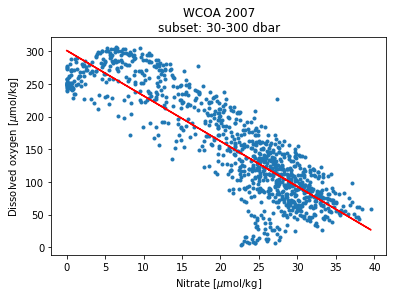

In [89]:
plt.figure()
plt.plot(df07['NITRAT'][ii],df07['CTDOXY'][ii],'.')
plt.plot(df07['NITRAT'][ii],
         df07['NITRAT'][ii]*result_NO.slope + result_NO.intercept,'r-')
plt.title('WCOA 2007\nsubset: 30-300 dbar')
plt.ylabel('Dissolved oxygen [$\mu$mol/kg]')
plt.xlabel('Nitrate [$\mu$mol/kg]')

Next, the regression of nitrate on oxygen, where oxygen is the independent variable. 

In [94]:
result_ON = stats.linregress(df07['CTDOXY'][ii],df07['NITRAT'][ii])
print(result_ON)

LinregressResult(slope=-0.1086940444642359, intercept=37.92852754022883, rvalue=-0.8689892897697765, pvalue=1.4711311081734e-310, stderr=0.0019485095957276586)


Text(0, 0.5, 'Nitrate [$\\mu$mol/kg]')

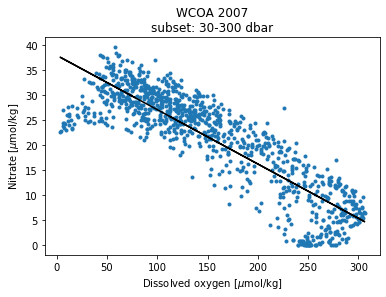

In [9]:
plt.figure()
plt.plot(df07['CTDOXY'][ii],df07['NITRAT'][ii],'.')
plt.plot(df07['CTDOXY'][ii],
         df07['CTDOXY'][ii]*result_ON.slope + result_ON.intercept,'k-')
plt.title('WCOA 2007\nsubset: 30-300 dbar')
plt.xlabel('Dissolved oxygen [$\mu$mol/kg]')
plt.ylabel('Nitrate [$\mu$mol/kg]')

*Note:* we could also use `statsmodels` to obtain the same results (and a lot more).

In [91]:
smres_NO = smf.ols('CTDOXY ~ NITRAT',df07[ii]).fit()
smres_NO.summary()

smres_ON = smf.ols('NITRAT ~ CTDOXY',df07[ii]).fit()
smres_ON.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 NITRAT   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     3112.
Date:                Tue, 10 Mar 2020   Prob (F-statistic):          1.47e-310
Time:                        17:40:45   Log-Likelihood:                -3054.3
No. Observations:                1011   AIC:                             6113.
Df Residuals:                    1009   BIC:                             6122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.9285      0.338    112.079      0.000      37.264      38.593
CTDOXY        -0.1087      0.002    -55.783      0.000      -0.113      -0.105
==============================================================================
Omnibus:                       69.600   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.415
Skew:                          -0.703   Prob(JB):                     7.70e-19
Kurtosis:                       2.935   Cond. No.                         376.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Comparing the Type I models

To compare the two Type I models, we can plot them on the same axes. We see that the two lines are similar, but have different slopes and intercepts. For variables that are highly correlated ($r \approx 1$), the two lines will be almost on top of each other. For variables that are uncorrelated ($r \approx 0$) the two lines will diverge greatly.

In all cases, both lines will pass through the means $\bar{x}$ and $\bar{y}$.

Text(0.5, 0, 'Nitrate [$\\mu$mol/kg]')

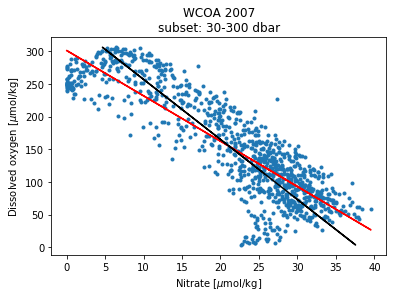

In [93]:
plt.figure()
plt.plot(df07['NITRAT'][ii],df07['CTDOXY'][ii],'.')
plt.plot(df07['NITRAT'][ii],
         df07['NITRAT'][ii]*result_NO.slope + result_NO.intercept,'r-')
plt.plot(df07['CTDOXY'][ii]*result_ON.slope + result_ON.intercept,
         df07['CTDOXY'][ii],'k-')
plt.title('WCOA 2007\nsubset: 30-300 dbar')
plt.ylabel('Dissolved oxygen [$\mu$mol/kg]')
plt.xlabel('Nitrate [$\mu$mol/kg]')

#### Simplest Type 2 regression - the geometric mean

The difference between the two Type 1 regression lines above can be used to illustrate one potential solution, the geometric mean regression. This is the line that bisects the two Type 1 regression lines. This can be thought of as a "compromise" between the two lines. An important assumption in this approach is that the uncertainty in each variable is assumed to be proportional to the sample standard deviation. If the uncertainty is dominated by natural variability, this might be a reasonable assumption. In cases, where the uncertainty is dominated by measurement error, there might be better ways of quantifying the uncertainty based on the analytical techniques. In this case, more sophisticated iterative approaches can be taken to determine the appropriate Type 2 regression model.

Detailed discussion can be found in Ricker, W. E. (1984) Computation and uses of central trend lines, *Can. J. Zool.*, 62, 1897-1905.

Glover, Jenkins and Doney provide an algorithm for determining the geometric mean regression slope:
* Determine the slope of the regression of $y$ on $x$, $slope_{yx}$
* Determine the slope of the regression of $x$ on $y$, $slope_{xy}$
* Calculate the geometric mean regression slope, $slope_{GMR} = \frac{slope_{yx}}{slope_{xy}}$
* Determine the intercept by noting that the regression line goes through the mean of $x$ and the mean of $y$

##### Exercise

Determine the slope and intercept of the geometric mean regression line.

### Multivariate regression ###

__Goal:__ Find a relationship that explains variable $y$ in terms of variables, $x_1, x_2, x_3, ...x_n$

<img src='images/mult_reg_viz.png' width="600">

source: [http://www.sjsu.edu/faculty/gerstman/EpiInfo/cont-mult.htm](http://www.sjsu.edu/faculty/gerstman/EpiInfo/cont-mult.htm)

This three dimensional visualization shows how linear model based on two predictor variables, $x_1$ and $x_2$ can be used to model a response variable $y$. A constant and two slopes to define a 2D plane in 3D space. The sum of squared vertical distances between the plane (model) and observations of $y$ are minimized. Like fitting a line in 2D space, this procedure assumes the validity of a linear model.

#### Example: Model for aragonite saturation state based on three other oceanographic variables

As a motivation for multiple linear regression, we consider a model for aragonite saturation state, $\Omega_A$. The study by Juranek et al. (2009), discussed on greater detail below, uses multiple linear regression to model $\Omega_A$ for surveys where it is not measured, using more commonly measured parameters. We know that $\Omega_A$ depends on both physical and biological processes, so one candidate for a model might be:

$y = b_0 + b_1x_1 + b_2x_2 + b_3x_3$

where $y$ = $\Omega_A$

$x_1$ = temperature

$x_2$ = salinity

$x_3$ = dissolved oxygen

$k$ = 3 predictor variables

$N$ = 1011 samples

Because we have three predictor variables, it is hard to visualize in four-dimensional space. However, the same principles are involved as fitting a 1D line in 2D space, or a 2D plane in 3D space.

#### Equations for linear model

A linear model can be represented as a system of $N$ equations.

$ b_0 + b_1x_{11} + b_2x_{12} + b_3x_{13} = \hat{y}_1 + \epsilon_1  $<br>
$ b_0 + b_1x_{21} + b_2x_{22} + b_3x_{23} = \hat{y}_2 + \epsilon_2 $<br>
$ b_0 + b_1x_{31} + b_2x_{32} + b_3x_{33} = \hat{y}_3  + \epsilon_3 $<br>
... <br>
$ b_0 + b_1x_{N1} + b_2x_{N2} + b_3x_{N3} = \hat{y}_N  + \epsilon_4 $<br>

where $\hat{y}_i$ is a modeled value and $\epsilon_i$ is the difference between the modeled value, $\hat{y}_i$ and an observation $y_i$. The least squares regression minimizes the sum of $\epsilon_i^2$, the overall deviation between the linear model and data.

#### Matrix form

To solve a least squares problem numerically, it helps to write the system of equations for the model in matrix form.

Form a vector $Y$ of $N$ observations of beach volume.

$ Y = \begin{bmatrix}
        y_1 \\
        y_2 \\
        y_3 \\
        \vdots \\
        y_n \\
        \end{bmatrix} $

A vector $B$ contains $k+1$ unknown coefficients.

$ B = \begin{bmatrix}
        b_0 \\
        b_1 \\
        b_2 \\
        b_3 \\
        \end{bmatrix} $

The predictor variables are stored as columns in a matrix with $N$ rows and $k+1$ columns

$
X =     \begin{bmatrix}
        1 & x_{11} & x_{12} & x_{13} \\
        1 & x_{21} & x_{22} & x_{23} \\
        1 & x_{31} & x_{32} & x_{33} \\
        \vdots & \vdots & \vdots     & \vdots \\
        1 & x_{N1} & x_{N2} & x_{N3} \\
        \end{bmatrix}
      $

Now the system of equations for the linear model can be written as

$ X B = Y $


#### Numerical solution

The least squares problem is solved using a singular value decomposition method. Efficient alorithms for this procedure are typically included in scientfic computing software. In Python, create an array for the vector $Y$ and a 2D array for the matrix $X$. Then use `np.linalg,lstsq` to solve for $B$.

```python
import numpy as np
B = np.linalg.lstsq(X,Y)
```

#### Testing for significance

##### F test 

Similar to ANOVA significance calculation, which also involves ratios of squared values.

$ \hat{y} = b_0 + b_1x_1 + b_2x_2 + b_3x_3 $

$H_0 : \hat{y} = C_0$ (All non-constant coefficients are zero)

$H_1 :$ At least one coefficient is non-zero

#### Total sum of squares <br>
$ SST =\sum_{j=1}^N{(y_j - \bar{y})^2} $

#### Regression sum of squares

$ SSR =\sum_{j=1}^N{(\hat{y_j} - \bar{y})^2} $

where $\hat{y_j}$ are model values


##### Error sum of squares

$ SSE =\sum_{j=1}^N{(y_i - \hat{y})^2} $

$MST =\frac{SST}{N-1}$

$MSR =\frac{SSR}{k}$ , where k is the number of variables

$MSE = \frac{SSE}{N-k-1}$


__F-statistic:__ 

$F = \frac{MSR}{MSE}$<br>

This test statistic can be compared with a critical F value, which depends on significance level $\alpha$ and the degrees of freedom in the numerator and denominator. If F is larger, then error is small. Find F using statistical tables, or `stats.f.ppf` in Python.



### Example: modeling aragonite saturation state


<img src='images/arag_sat.png' width="600">

Source: Feeley et al. (2208) Evidence for upwelling of corrosive acidification water onto the continental shelf, Science

At Aragonite staturation state > 1 aragonite (calcium carbonate will dissolve in seawater)

Is there a way to estimate aragonite saturation state $\Omega_{Ar}$ based on more commonly measured parameters?

$ \Omega = \frac{[Ca^{2+}][CO_3^{2-}]}{K'_{sp}} $<br>
Where $K'_{sp}$ is the stoichiometric solubility product function of T,S,pr and mineral phase (aragonite, calcite)

$[Ca^{2+}]$  doesn't change much<br>
$[CO_3^{2+}]$ can be calculated from chemical measurements of DIC, $pCO_2$, total alkalinity and pH (at least two of these 4 parameters).

#### Models

Juranek et al. (2009) describe a set of least squares regression models for aragonite saturation state, based on more commonly measured oceangraphic variables (temperature, salinity, pressure, oxygen and nitrate).

Juranek, L. W., R. A. Feely, W. T. Peterson, S. R. Alin, B. Hales, K. Lee, C. L. Sabine, and J. Peterson, 2009: A novel method for determination of aragonite saturation state on the continental shelf of central Oregon using multi-parameter relationships with hydrographic data. Geophys. Res. Lett., 36, doi:10.1029/2009GL040778.

##### Model 1 

$\Omega_{arag}^e = \beta_0 + \beta_1T + \beta_2S + \beta_3P + \beta_4O_2 + \beta_5NO_3^-$

* Has high $R_a^2$ ("adjusted" $R^2$)
* High "variance inflation factor"
* Indicates multiple collinearity
* Coefficients are ambiguous and not meaningful - When you add more data, you get will get a different answer (this is bad!)

##### Adjusted $R^2$

Accounts for reduction of degrees of freedom when using multiple predictor variables.

$R_a^2 = R^2 - (1-R^2)\frac{k}{n-k-1}$

$= 1 - \frac{MSE}{MST}$

If the MSE is low, the adjusted R-squared is going to be high. The more observations you have, the less this adjustment matters.


##### Variance Inflation Factor

$ VIF  = \frac{1}{1 - R^2}$ Variance Inflation Factor

where $R^2 $ from regression of predictor variables against other predictor variables. There is no clear "cut-off" that defines high VIF, but greater than 5 (and definitely greater than 10) is generally considered high.

<img src='images/arag_sat_table.png' width="600">

##### Final Model

$\Omega_{arag}^e = \alpha_0 + \alpha_1(O_2 - O_{2,r}) + \alpha_2(T - T_r) \times (O_2 - O_{2,r}) $

* Less variables, avoids multiple collinearity
* Includes interaction term
* Reference values ($T_r$ and $O_{2,r}$) keep product from getting too big
* Using variables with differing magnitudes can lead to problems like round-off errors
* Standardizing variables (using z-scores) another common strategy

<img src='images/arag_sat_final.png' width="600">


__Aragonite saturation state__

_Red contours:_ from measured DIC and total alkalinaity

_Blue contours:_ Multiple regression model

__Application of the model to time series that do not have direct observations of the carbonate system parameters__

<img src='images/arag_sat_ts.png' width="600">


## Common statistical tests as linear models ##

Many statistical tests can be though of as implementations of the generalized linear model. Thinking of tests as part of a class of linear models can be more intuitive than thinking about how each test works individually.

### Resources

This approach is taken in Chapter 28 of *Statistical Thinking for the 21st Century* on comparing means:
* http://statsthinking21.org/comparing-means.html

A blog post by Jonas Kristoffer Lindeløv explains this approach for a wide array of statistical tests. Implementation of the statistical functions and linear models, with interpretations, are provided in both R and Python.
* Original post (using R): https://lindeloev.github.io/tests-as-linear/
* Python port: https://eigenfoo.xyz/tests-as-linear/

### Examples

The following examples show different ways of comparing means, using data from the 2007 West Coast Ocean Acidification cruise. The examples use quality controlled data from 0-10 dbar (upper 10m of the water column).

#### Comparing one sample mean to a single value

In this example the goal is to test whether the mean aragonite saturation state is different from a value of 1, a critical threshold for the ability of organisms to form calcium carbonate shells.

* $H_0$: $\bar{\Omega}_A = $ 1
* $H_A$: $\bar{\Omega}_A \neq$ 1 

The first step is to create a subset of good data from the upper 10m.

In [70]:
iisurf07 = ((df07['CTDPRS'] <= 10) &
      (df07['NITRAT_FLAG_W'] == 2) & (df07['PHSPHT_FLAG_W'] == 2)
      & (df07['CTDOXY_FLAG_W'] == 2) & (df07['CTDSAL_FLAG_W'] == 2) 
        & (df07['ALKALI_FLAG_W'] == 2) & (df07['TCARBN_FLAG_W'] == 2))

df07surf = df07[iisurf07]

A box plot is one way of showing the distribution of $\Omega_A$ values.
* Orange line: median, or 50th percentile
* Upper/lower limits on box: interquartile range, or 75th/25th percentiles
* Whiskers: each have length 1.5*interquartile range (pyplot default)
* Circles: extreme values
* Green triangle: mean
* Notches on box: 95% confidence intervals for median

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

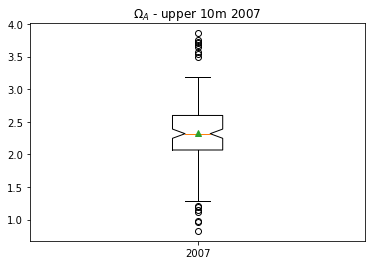

In [71]:
plt.figure()
plt.boxplot(np.array(df07['OmegaA'][iisurf07]),labels=['2007'],showmeans=True,notch=True);
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: one sample t-test

A one-sample t-test can be used to test whether the null hypothesis can be rejected at the 95% confidence level ($\alpha$ = 0.05). 

In [72]:
stats.ttest_1samp(np.array(df07surf['OmegaA']),popmean=1)

Ttest_1sampResult(statistic=28.43230570935999, pvalue=2.5238884999372847e-59)

##### Method 2: generalized linear model

Alternatively, this test can be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x ,$$

In this application, $y$ represents the $\Omega_A$ data. There is only one group, so we can set $x = 0$ for all values, making the slope parameter $\hat{a}_2$ irrelevant. The model then reduces to

$$ \hat{y} = \hat{a}_1 ,$$

or a model for the intercept parameter only. This equation can also be expressed as

$$ \hat{y} = \hat{a}_1 \times 1.$$

This model for the data in terms of a constant intercept can be implemented with the `statsmodels` library:

In [73]:
res = smf.ols(formula="OmegaA ~ 1", data=df07surf).fit()

The summary of the results shows that the intercept is 2.33, which is also the mean of the data. The 95% confidence intervals do not overlap with 1, which means that the null hypothesis can be rejected at $\alpha$ = 0.05. This approach to hypothesis testing will give the same results as the one sample t-test for $N$ > 14.

Notice that the test statistic $t$ is different from the one sample t-test. This is because `statsmodels` automatically tests whether parameters are different from *zero*, while in this case we are interested in whether the mean/intercept is different from *one*.

In [74]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 10 Mar 2020   Prob (F-statistic):                nan
Time:                        16:40:13   Log-Likelihood:                -112.79
No. Observations:                 138   AIC:                             227.6
Df Residuals:                     137   BIC:                             230.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.3309      0.047     49.795      0.000       2.238       2.423
==============================================================================
Omnibus:                        7.528   Durbin-Watson:                   0.666
Prob(Omnibus):                  0.023   Jarque-Bera (JB):               12.146
Skew:                           0.195   Prob(JB):                      0.00230
Kurtosis:                       4.400   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means

We can also apply the generalized linear model approach when comparing two means. In this case, we will examine whether there is a statistically significant difference between the mean of $\Omega_A$ to the north and south of Cape Mendocino. At a latitude of 40.4$^o$N, Cape Mendocino represents a sharp transition point in many oceanographic processes and water masses.

The first steps are to make two subsets based on latitude, and then visualize the results in a box plot.

In [75]:
# create a new boolean variable in the df07surf dataframe
df07surf = df07[iisurf07]
df07surf = df07surf.assign(is_northern = df07surf['LATITUDE'] > 40.4);

iinorth = np.array(df07surf.is_northern == True)
iisouth = np.array(df07surf.is_northern == False)

Text(0.5, 1.0, '$\\Omega_A$ - upper 10m 2007')

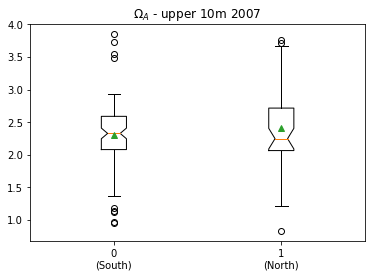

In [76]:
plt.figure()
plt.boxplot([df07surf['OmegaA'][iisouth],df07surf['OmegaA'][iinorth]],
            labels=['0\n(South)','1\n(North)'],showmeans=True,notch=True)
plt.title('$\Omega_A$ - upper 10m 2007')

##### Method 1: t-test

There is a difference of 0.104 in the mean of $\Omega_A$ between the two regions.

In [77]:
np.mean(df07surf['OmegaA'][iinorth]) - np.mean(df07surf['OmegaA'][iisouth])

0.10427563391405359

Is this difference statistically significant? A Student's t-test can be used to test whether the null hypothesis of no difference can be rejected at the 95% confidence level. 

In [78]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=True)

Ttest_indResult(statistic=1.0251798309255598, pvalue=0.30709834696023874)

A Welch's t-test relaxes the assumption of equal variance.

In [79]:
stats.ttest_ind(df07surf['OmegaA'][iinorth],df07surf['OmegaA'][iisouth],equal_var=False)

Ttest_indResult(statistic=0.9223324103895281, pvalue=0.35989367953568807)

##### Method 2: generalized linear model

This test can also be framed in terms of a general linear model

$$ \hat{y} = \hat{a}_1 + \hat{a}_2 x .$$

Again, $\hat{y}$ is a model for the aragonite saturation state data. In this case, we can think of the southern data points as having $x = 0$ and the northern data points as having $x = 1$.

In this model, the intercept parameter $\hat{a}_1$ is the mean of the points with $x = 0$, the southern points.

The slope parameter $\hat{a}_2$ is equal to the difference between the means of the two groups.

$$ slope = \frac{\Delta\bar{y}}{\Delta x} = \frac{\Delta\bar{y}}{1} = \Delta\bar{y}$$ 

In [80]:
res = smf.ols(formula="OmegaA ~ is_northern", data=df07surf).fit()

The results are summarized below. The slope parameter $\hat{a}_2$ in our model is the coefficient for the `is_northern` variable. This is a Boolean variable that is equal to 0 (`False`) for southern points and 1 (`True`) for northern points. Notice that this coefficient is equal to 0.104, which the same as the difference between the two means.

Also notice that the 95% confidence intervals (shown as the `[0.025 0.975]` interval) overlap 0 for this parameter. This means that the difference is not statistically significant at the 95% confidence ($\alpha$ = 0.05) level. This summary also shows a t-statistic and p-value for this parameter, which are equivalent to the Student's t-test result shown above.

In [81]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 OmegaA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.051
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.307
Time:                        16:40:16   Log-Likelihood:                -112.25
No. Observations:                 138   AIC:                             228.5
Df Residuals:                     136   BIC:                             234.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.2992      0.056     40.974      0.000       2.188       2.410
is_northern[T.True]     0.1043      0.102      1.025      0.307      -0.097       0.305
==============================================================================
Omnibus:                        6.623   Durbin-Watson:                   0.673
Prob(Omnibus):                  0.036   Jarque-Bera (JB):               10.616
Skew:                           0.126   Prob(JB):                      0.00495
Kurtosis:                       4.335   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Comparing two sample means (another example)

The following shows the same calculations for temperature. In this case, the null hypothesis can be rejected at the 95% confidence level, and the 95% confidence intervals for the model slope do *not* overlap with zero.

Text(0.5, 1.0, 'CTDTMP - upper 10m 2007')

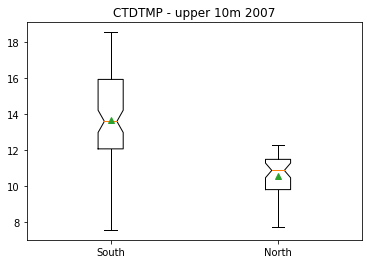

In [82]:
plt.figure()
plt.boxplot([df07surf['CTDTMP'][iisouth],df07surf['CTDTMP'][iinorth]],
            labels=['South','North'],showmeans=True,notch=True);
plt.title('CTDTMP - upper 10m 2007')

In [83]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=True)

Ttest_indResult(statistic=-7.3756898407987945, pvalue=1.4522086213500461e-11)

In [84]:
stats.ttest_ind(df07surf['CTDTMP'][iinorth],df07surf['CTDTMP'][iisouth],equal_var=False)

Ttest_indResult(statistic=-9.799130523807381, pvalue=1.7823812194777806e-17)

In [85]:
res = smf.ols(formula="CTDTMP ~ is_northern", data=df07surf).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 CTDTMP   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     54.40
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           1.45e-11
Time:                        16:40:18   Log-Likelihood:                -310.63
No. Observations:                 138   AIC:                             625.3
Df Residuals:                     136   BIC:                             631.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              13.6931      0.236     57.959      0.000      13.226      14.160
is_northern[T.True]    -3.1587      0.428     -7.376      0.000      -4.006      -2.312
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   0.191
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.064
Skew:                          -0.408   Prob(JB):                        0.131
Kurtosis:                       3.202   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""